In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from FDTDStaggered3D_with_relaxation.H5pySimple import ReadFromH5py,SaveToH5py
from FDTDStaggered3D_with_relaxation.PropagationModel import PropagationModel
from scipy import ndimage
PModel=PropagationModel()


### Preamble
Please consult first the examples in the `1 - Flat source homgenous medium.ipynb` and `2 - Control of directivity .ipynb` notebooks for the basics how to run a simulation and understanding of how to prepare correctly the directivity of a source


In this example we apply the previous concepts to model a focused source

# 1 - Focused source


In [21]:
Frequency = 350e3  # Hz
MediumSOS = 1500 # m/s - water
MediumDensity=1000 # kg/m3

ShortestWavelength =MediumSOS / Frequency
SpatialStep =ShortestWavelength / 8.0 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.05,0.05,0.08])  # in m, x,y,z

TxRadius = 0.04 # m, ciruclar piston
TxDiameter=0.04
TxPlaneLocation = 0.01  # m , in XY plane at Z = 0.01 m

PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, IGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/MediumSOS #time to cross one corner to another
TemporalStep=1e-7 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((1,5)) # one material in this examples
MaterialList[0,0]=MediumDensity # water density
MaterialList[0,1]=MediumSOS # water SoS
#all other parameters are set to 0 


Domain size 118 118 174


0.034641016151377546
0 -0.0005357142857142852


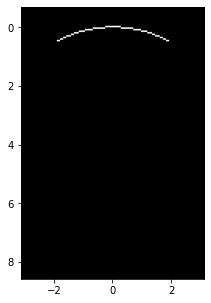

In [22]:
# from scipy import ndimage
def MakeFocusingSource(DimX,DimY,DimZ,SpatialStep,Radius,Diameter,TxPlaneLocation,PMLThickness):
    #simple defintion of a focusing source centred in the domain, 
    #please note this is not a bullet-proof solution as it will not work for all cases
    #for example, it assumes the source is oriented towards the Z+ direction
    XDim=np.arange(DimX)*SpatialStep
    YDim=np.arange(DimY)*SpatialStep
    ZDim=np.arange(DimZ)*SpatialStep
    XDim-=XDim.mean()
    YDim-=YDim.mean()
    ZDim-=ZDim.mean()
    XX,YY,ZZ=np.meshgrid(XDim,YDim,ZDim)
    MaskSource=(XX**2+YY**2+ZZ**2)<=Radius**2
    MaskSource=np.logical_xor(MaskSource,ndimage.binary_erosion(MaskSource))
    Depth=np.sqrt(Radius**2-(Diameter/2.0)**2)
    print(Depth)
    MaskSource[ZZ>-Depth]=False
    #since the sphere mask is 0-centred, the orientation vectors in each point is straighforward
    OxOyOz=np.vstack((-XX.flatten(),-YY.flatten(),-ZZ.flatten())).T
    #and we just normalize
    OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])
    Ox=OxOyOz[:,0].reshape(XX.shape)
    Oy=OxOyOz[:,1].reshape(XX.shape)
    Oz=OxOyOz[:,2].reshape(XX.shape)
    Ox[MaskSource==False]=0
    Oy[MaskSource==False]=0
    Oz[MaskSource==False]=0
    #finally, we jut move the mask to match the location of the Tx
    ZDim=np.arange(DimZ)*SpatialStep-(PMLThickness+1)*SpatialStep
    XX,YY,ZZ=np.meshgrid(XDim,YDim,ZDim)
    Zmin=ZZ[MaskSource].min()
    StepsToMove=int(np.round(TxPlaneLocation-Zmin)/SpatialStep)
    print(StepsToMove,Zmin)
    MaskSource=np.roll(MaskSource,StepsToMove,axis=2)
    return MaskSource.astype(np.uint32),Ox,Oy,Oz

SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,TxPlaneLocation,PMLThickness)
XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray,extent=[XDim.min(),XDim.max(),ZDim.max(),ZDim.min()]);


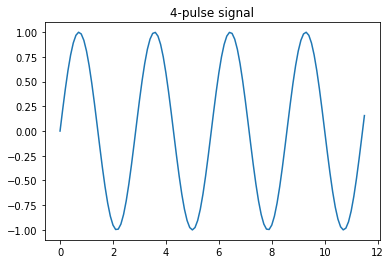

In [23]:
LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 

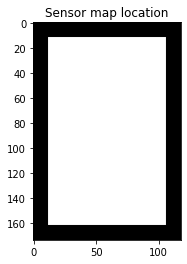

In [24]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

plt.figure()
plt.imshow(SensorMap[:,int(N2/2),:].T,cmap=plt.cm.gray)
plt.title('Sensor map location');

In [25]:
Sensor,LastMap,RMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=2,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         DefaultGPUDeviceName='Radeon',
                                                         TypeSource=1)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 118 x 118 x 174 , spatial resolution = 0.000535714, time steps = 712, temporal step = 1e-07, total sonication length 7.11805e-05 
Performing Simulation wtih GPU OPENCL
Copying opencl files from /Users/spichardo/.edm/envs/MORPHEUS36/include/python3.6m/FDTDStaggered3D-with-relaxation/ to /Users/spichardo/Documents/GitHub/FDTDStaggered3D_with_relaxation/Example Notebooks
Running with new interface conditions
SizePML=1097377
SizePMLxp1=1117909
SizePMLyp1=1117909
SizePMLzp1=1111301
SizePMLxp1yp1zp1=1152776
 Staggered FDTD - compiled at Dec 27 2020 - 18:34:07
N1, N2,N3 , ZoneCount and D

### Ploting data

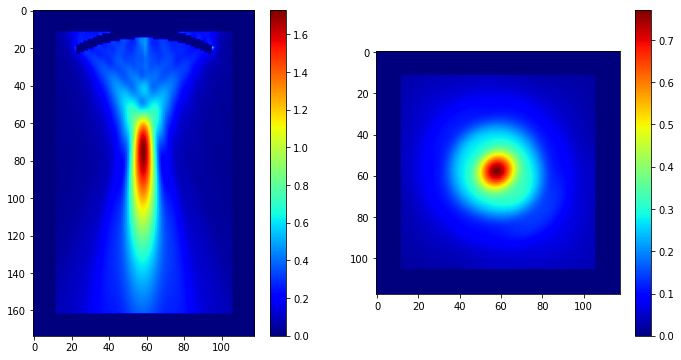

In [26]:
#RMSValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
for n in range(-2,3):
    RMSValue[np.roll(SourceMap>0,n,axis=2)]=0. #we turn off the values close the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T,cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,125].T,cmap=plt.cm.jet)
plt.colorbar();

We can see the focused field produced by the concave source

We calculate now peak and RMS values from the sensor data

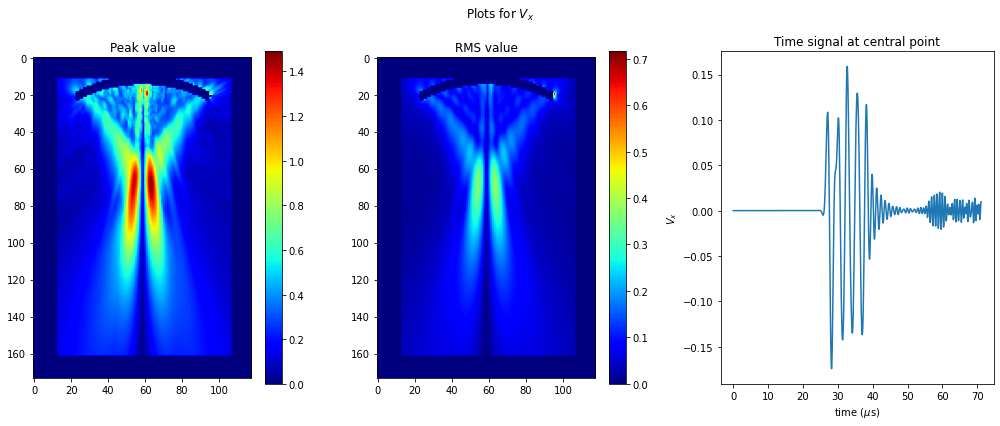

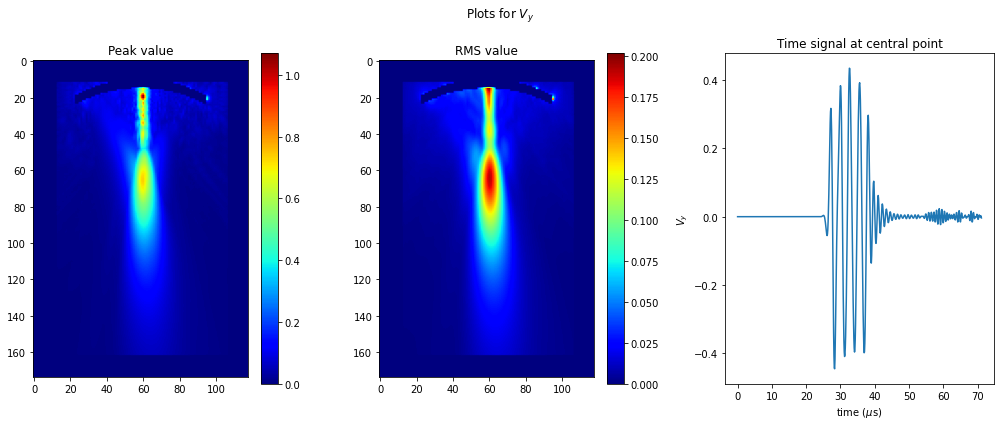

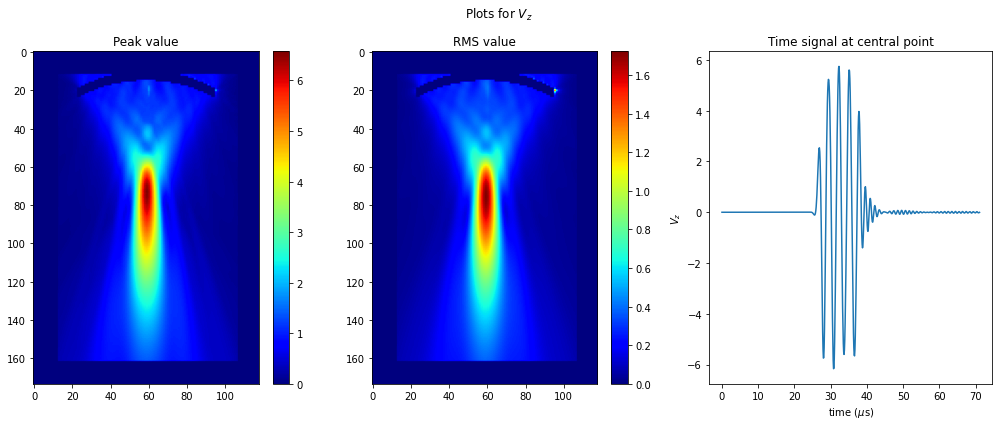

In [27]:
#To remain compatible with Matlab (whcih uses a Fortran convention for arrays, the index need to be rebuilt)
MaxSensorPlane=np.zeros((N1,N3))
RMSSensorPlane=np.zeros((N1,N3))

for s in ['Vx','Vy','Vz']:
    #We use the IndexSensorMap array that was used in the low level function to 
    for n, index in enumerate( InputParam['IndexSensorMap']): 
        k=int(index/(N1*N2))
        j=int(index%(N1*N2))
        i=int(j%N1)
        j=int(j/N1)
        assert(j==N2/2) #all way up we specified the XZ plane at N2/2, this assert should pass
        if i==int(N1/2) and k==int(N3/2):
            CentralPoint=n #we save this to later plot the time signal at the center
        MaxSensorPlane[i,k]=np.max(Sensor[s][n,:])
        RMSSensorPlane[i,k]=np.sqrt(1./len(Sensor[s][n,:])*np.sum(Sensor[s][n,:]**2))
    for n in range(-2,3):
        MaxSensorPlane[np.roll(SourceMap[:,j,:]>0,n,axis=1)]=0. #we turn off the values close the source 
        RMSSensorPlane[np.roll(SourceMap[:,j,:]>0,n,axis=1)]=0
    

    plt.figure(figsize=(14,6))
    plt.subplot(1,3,1)
    plt.imshow(MaxSensorPlane.T,cmap=plt.cm.jet)
    plt.title('Peak value')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(RMSSensorPlane.T,cmap=plt.cm.jet)
    plt.title('RMS value')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(Sensor['time']*1e6,Sensor[s][CentralPoint])
    plt.xlabel('time ($\mu$s)')
    plt.ylabel('$'+s[0]+'_'+s[1]+'$')
    plt.title('Time signal at central point')
    plt.suptitle('Plots for $'+s[0]+'_'+s[1]+'$')
    plt.tight_layout()
